# Trying to generate Music with JSBChorales using VAE

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import joblib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
X = datas['X']
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # to 1 channel

from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=64, shuffle=True)


In [20]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    mse = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = 0 - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) + mse

    return reproduction_loss + KLD

In [21]:
class BachBlock(nn.Module):
    def __init__(self, heads=1):
        super().__init__()
        layers = []
        # qui potrei fare transpose per aumentare il constrasto
        for head in range(heads):
            layers.append(nn.Conv2d(1, 84, kernel_size=(24, 24), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(84, 64, kernel_size=(10, 10), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(64, 1, kernel_size=(5, 5), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))

        self.mod = nn.Sequential(*layers)

    def forward(self, x):
        x = self.mod(x) + x
        return x


class BachVAE(nn.Module):
    def __init__(self):
        super(BachVAE, self).__init__()
        self.preprocessor = BachBlock(2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=(8, 8), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 2, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2)
        )

        self.d1 = nn.Dropout(0.2)
        self.ztodec = nn.Linear(32, 1024)

        self.mean_layer = nn.Linear(240, 32)
        self.logvar_layer = nn.Linear(240, 32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 256, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=(9, 7), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 1, kernel_size=(16, 16), stride=(4, 2)),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.d1(x)
        x = x.flatten(1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        var = torch.exp(logvar)
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        # x = self.preprocessor(x)
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        z = self.ztodec(z)
        z = z.view(z.shape[0], 8, 8, 16)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


model = BachVAE().to(device)
optim = Adam(model.parameters(), lr=0.001)
criterion = loss_function
twogpu = False
if torch.cuda.device_count() > 1:
        print("using", torch.cuda.device_count(), "GPUs")
        model = nn.DataParallel(model).cuda()
        twogpu = True



In [158]:
model.train()
for epoch in range(2):
    for batch_idx, x in enumerate(dataloader):
        x = x.float().to(device)
        optim.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()
        optim.step()

    print(epoch, loss.item())

0 7596.58935546875
1 7744.00634765625


torch.Size([44, 1, 128, 100])


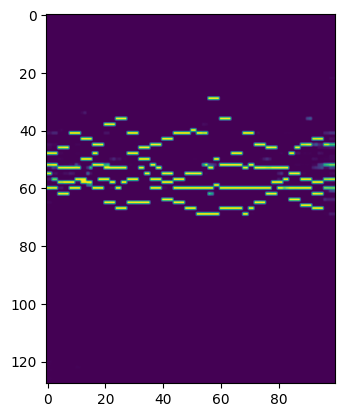

In [159]:
model.eval()
with torch.no_grad():
    _x = x.float().to(device)
    _x_hat, mean, log_var = model(_x)

_x_hat = _x_hat.cpu().numpy()[2, 0, :, :]
print(x_hat.shape)
plt.imshow(_x_hat)

# Generating Samples from learned Distribution

In [160]:
def generate_sample_distr(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

['VAEpred2.pkl']

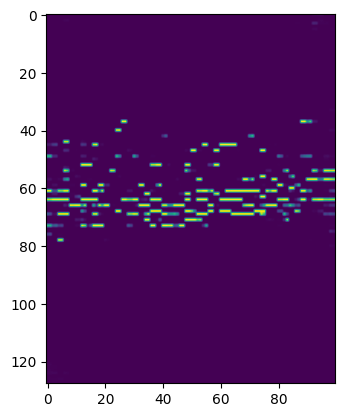

In [169]:
with torch.no_grad():
    mean = torch.randn(1, 32).to(device)*-0.1
    logvar = torch.randn(1, 32).to(device)*0.1
    z = model.reparameterization(mean, logvar)
    z = model.ztodec(z)
    z = z.view(z.shape[0], 8, 8, 16)
    new_sample = model.decode(z)

new_sample = new_sample.cpu().numpy()[0, 0, :, :]

plt.imshow(new_sample)

joblib.dump(new_sample, "VAEpred2.pkl")

### Per quanto è ancora molto basilare è promettente (credo)

In [170]:
torch.save(model.state_dict(), "BachVAE2.pt")


In [ ]:
model.load_state_dict(torch.load("/kaggle/working/BachVAE1.pt", weights_only=True))
model.eval()